# Notebook 02: GapMind Pathway Analysis

**Goal**: Identify universally complete metabolic pathways across Fitness Browser organisms

**Research Question**: Which metabolic pathways are universally complete across bacteria with essential gene data?

**Data sources**:
- Essential gene families: `projects/essential_genome/` (45 FB organisms)
- FB → genome mapping: Manual mapping for subset of organisms
- GapMind predictions: `kbase_ke_pangenome.gapmind_pathways` (305M predictions)

**Approach**:
1. Load FB organism list (45 organisms from essential_genome)
2. Load manual genome mapping (currently 8 organisms)
3. Extract GapMind predictions for mapped genomes
4. Identify universally complete pathways
5. Characterize essential metabolic repertoire

**Note**: This uses revised approach (v2) - pathway-level analysis instead of EC→reactions

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Spark Connect
from get_spark_session import get_spark_session

print("✅ Imports successful")

✅ Imports successful


In [2]:
# Create Spark session
spark = get_spark_session()
print(f"✅ Spark session created: version {spark.version}")

✅ Spark session created: version 4.0.1


## Step 1: Load FB Organism List

Get the 45 organisms from essential_genome project.

In [3]:
# Download essential families from lakehouse (or use cached)
# This references data from essential_genome project (proper attribution)

import os

essential_families_file = Path("../data/essential_genome_families.tsv")

if not essential_families_file.exists():
    print("Downloading essential families from lakehouse...")
    os.system(f"""
        export https_proxy=http://127.0.0.1:8123 && 
        export no_proxy=localhost,127.0.0.1 && 
        mc cp berdl-minio/cdm-lake/tenant-general-warehouse/microbialdiscoveryforge/projects/essential_genome/data/essential_families.tsv {essential_families_file}
    """)
    print(f"✅ Downloaded to {essential_families_file}")
else:
    print(f"✅ Using cached file: {essential_families_file}")

# Load
families = pd.read_csv(essential_families_file, sep='\t')
print(f"\nLoaded {len(families):,} ortholog groups")
print(f"Universally essential: {(families['essentiality_class'] == 'universally_essential').sum():,}")

✅ Using cached file: ../data/essential_genome_families.tsv

Loaded 17,222 ortholog groups
Universally essential: 859


In [4]:
# Extract organism names from essential_organisms column

universal = families[families['essentiality_class'] == 'universally_essential']
organism_str = universal.iloc[0]['essential_organisms']
fb_organisms = sorted(organism_str.split(';'))

print(f"FB organisms ({len(fb_organisms)}):")
for i, org in enumerate(fb_organisms, 1):
    print(f"{i:2d}. {org}")

FB organisms (45):
 1. ANA3
 2. BFirm
 3. Btheta
 4. Burk376
 5. Caulo
 6. Cola
 7. Cup4G11
 8. Dda3937
 9. Ddia6719
10. DdiaME23
11. Dino
12. DvH
13. HerbieS
14. Kang
15. Keio
16. Korea
17. Koxy
18. MR1
19. Magneto
20. Marino
21. Miya
22. PS
23. PV4
24. Pedo557
25. Phaeo
26. Ponti
27. Putida
28. RalstoniaBSBF1503
29. RalstoniaGMI1000
30. RalstoniaPSI07
31. RalstoniaUW163
32. SB2B
33. Smeli
34. SynE
35. SyringaeB728a
36. SyringaeB728a_mexBdelta
37. WCS417
38. acidovorax_3H11
39. azobra
40. psRCH2
41. pseudo13_GW456_L13
42. pseudo1_N1B4
43. pseudo3_N2E3
44. pseudo5_N2C3_1
45. pseudo6_N2E2


## Step 2: Load FB → Genome Mapping

Load the manual mapping file that maps FB organism names to pangenome genome IDs.

**Note**: The pangenome genome table lacks `ncbi_taxid` column, so we use manual mappings for known organisms.

In [5]:
# Load manual mapping
mapping_file = Path("../data/fb_genome_mapping_manual.tsv")
fb_genome_map = pd.read_csv(mapping_file, sep='\t')

print(f"Loaded {len(fb_genome_map)} FB organism → genome mappings")
print("\nMapped organisms:")
print(fb_genome_map.to_string(index=False))

# Check coverage
mapped_orgs = set(fb_genome_map['orgId'])
all_orgs = set(fb_organisms)
unmapped_orgs = all_orgs - mapped_orgs

print(f"\nMapping coverage:")
print(f"  Mapped: {len(mapped_orgs)}/{len(fb_organisms)} ({100*len(mapped_orgs)/len(fb_organisms):.1f}%)")
print(f"  Unmapped: {len(unmapped_orgs)}")

if len(unmapped_orgs) > 0:
    print(f"\n⚠️  Analysis will proceed with {len(mapped_orgs)} organisms")
    print(f"   Unmapped organisms can be added incrementally")

Loaded 8 FB organism → genome mappings

Mapped organisms:
 orgId       genome_id            species_name                                notes
  Keio GCF_000005845.2        Escherichia_coli          E. coli K-12 substr. MG1655
   DvH GCF_000195755.1  Desulfovibrio_vulgaris Desulfovibrio vulgaris Hildenborough
   MR1 GCF_000146165.2   Shewanella_oneidensis           Shewanella oneidensis MR-1
Putida GCF_000007565.2      Pseudomonas_putida            Pseudomonas putida KT2440
    PS GCF_000006765.1  Pseudomonas_aeruginosa          Pseudomonas aeruginosa PAO1
 Caulo GCF_000022005.1  Caulobacter_vibrioides          Caulobacter crescentus CB15
 Smeli GCF_000006965.1  Sinorhizobium_meliloti          Sinorhizobium meliloti 1021
azobra GCF_000011365.1 Azospirillum_brasilense        Azospirillum brasilense Sp245

Mapping coverage:
  Mapped: 8/45 (17.8%)
  Unmapped: 37

⚠️  Analysis will proceed with 8 organisms
   Unmapped organisms can be added incrementally


## Step 3: Extract GapMind Predictions

Query GapMind pathway predictions for the mapped genomes.

In [6]:
# Get GapMind predictions for mapped organisms
genome_list = "','".join(fb_genome_map['genome_id'].tolist())
n_genomes = len(fb_genome_map)

print(f"Querying GapMind for {n_genomes} genomes...")

gapmind_fb = spark.sql(f"""
    SELECT genome_id, pathway, metabolic_category, sequence_scope, 
           score_category, score, nHi, nMed, nLo
    FROM kbase_ke_pangenome.gapmind_pathways
    WHERE genome_id IN ('{genome_list}')
""").toPandas()

print(f"✅ Retrieved {len(gapmind_fb):,} GapMind predictions")
print(f"   Unique pathways: {gapmind_fb['pathway'].nunique()}")
print(f"   Unique genomes: {gapmind_fb['genome_id'].nunique()}")

print("\nScore category distribution:")
print(gapmind_fb['score_category'].value_counts())

print("\nMetabolic category distribution:")
print(gapmind_fb['metabolic_category'].value_counts())

Querying GapMind for 8 genomes...


✅ Retrieved 7,389 GapMind predictions
   Unique pathways: 80
   Unique genomes: 7

Score category distribution:
score_category
not_present             3366
complete                2204
steps_missing_low       1215
likely_complete          390
steps_missing_medium     214
Name: count, dtype: int64

Metabolic category distribution:
metabolic_category
carbon    6216
aa        1173
Name: count, dtype: int64


## Step 4: Identify Universally Complete Pathways

Find pathways that are complete or likely_complete in ALL mapped organisms.

In [7]:
# Join genome_id back to orgId for interpretability
gapmind_with_org = gapmind_fb.merge(
    fb_genome_map[['orgId', 'genome_id', 'species_name']], 
    on='genome_id', 
    how='left'
)

print(f"✅ Joined organism names")
print("\nSample:")
print(gapmind_with_org[['orgId', 'pathway', 'metabolic_category', 'score_category']].head(10).to_string(index=False))

✅ Joined organism names

Sample:
orgId    pathway metabolic_category score_category
Smeli        arg                 aa       complete
Smeli        arg                 aa       complete
Smeli        asn                 aa       complete
Smeli        asn                 aa       complete
Smeli        asn                 aa       complete
Smeli        asn                 aa       complete
Smeli chorismate                 aa       complete
Smeli chorismate                 aa       complete
Smeli chorismate                 aa       complete
Smeli        cys                 aa       complete


In [8]:
# Count how many organisms have each pathway as complete/likely_complete

pathway_completeness = gapmind_with_org[
    gapmind_with_org['score_category'].isin(['complete', 'likely_complete'])
].groupby(['pathway', 'metabolic_category']).agg({
    'genome_id': 'nunique'
}).rename(columns={'genome_id': 'n_complete'}).reset_index()

pathway_completeness['pct_complete'] = 100 * pathway_completeness['n_complete'] / n_genomes
pathway_completeness = pathway_completeness.sort_values('n_complete', ascending=False)

print(f"Pathway completeness across {n_genomes} FB organisms:")
print(f"  Universally complete (100%): {(pathway_completeness['n_complete'] == n_genomes).sum()}")
print(f"  Nearly universal (≥90%): {(pathway_completeness['pct_complete'] >= 90).sum()}")
print(f"  Majority (≥75%): {(pathway_completeness['pct_complete'] >= 75).sum()}")
print(f"  Half or more (≥50%): {(pathway_completeness['pct_complete'] >= 50).sum()}")

print("\nTop 30 most complete pathways:")
print(pathway_completeness.head(30).to_string(index=False))

Pathway completeness across 8 FB organisms:
  Universally complete (100%): 0
  Nearly universal (≥90%): 0
  Majority (≥75%): 53
  Half or more (≥50%): 67

Top 30 most complete pathways:
      pathway metabolic_category  n_complete  pct_complete
     fumarate             carbon           7          87.5
  deoxyribose             carbon           7          87.5
          pro                 aa           7          87.5
    threonine             carbon           7          87.5
          gln                 aa           7          87.5
          thr                 aa           7          87.5
    succinate             carbon           7          87.5
    glutamate             carbon           7          87.5
          gly                 aa           7          87.5
       serine             carbon           7          87.5
          his                 aa           7          87.5
          ile                 aa           7          87.5
   isoleucine             carbon           7   

In [9]:
# Identify universally complete pathways
universal_pathways = pathway_completeness[
    pathway_completeness['n_complete'] == n_genomes
]

if len(universal_pathways) > 0:
    print(f"\n🎯 {len(universal_pathways)} Universally Complete Pathways (100%):")
    print("=" * 70)
    for _, row in universal_pathways.iterrows():
        print(f"  {row['pathway']:15s} ({row['metabolic_category']:6s})")
else:
    print("\n⚠️  No pathways are universally complete across all mapped organisms")
    
# Check nearly universal pathways (≥90%)
nearly_universal = pathway_completeness[
    (pathway_completeness['pct_complete'] >= 90) & 
    (pathway_completeness['pct_complete'] < 100)
]

if len(nearly_universal) > 0:
    print(f"\n📊 {len(nearly_universal)} Nearly Universal Pathways (≥90%):")
    print(nearly_universal[['pathway', 'metabolic_category', 'n_complete', 'pct_complete']].to_string(index=False))


⚠️  No pathways are universally complete across all mapped organisms


## Step 5: Analyze by Metabolic Category

Break down pathway completeness by amino acids vs carbon sources.

In [10]:
# Amino acid biosynthesis pathways
aa_pathways = pathway_completeness[pathway_completeness['metabolic_category'] == 'aa'].copy()
aa_pathways = aa_pathways.sort_values('n_complete', ascending=False)

print(f"Amino Acid Biosynthesis Pathways ({len(aa_pathways)} total):")
print(f"  Universally complete: {(aa_pathways['n_complete'] == n_genomes).sum()}")
print(f"  Nearly universal (≥90%): {(aa_pathways['pct_complete'] >= 90).sum()}")
print(f"  Majority (≥75%): {(aa_pathways['pct_complete'] >= 75).sum()}")

print("\nAmino acid pathway completeness:")
print(aa_pathways.to_string(index=False))

Amino Acid Biosynthesis Pathways (18 total):
  Universally complete: 0
  Nearly universal (≥90%): 0
  Majority (≥75%): 18

Amino acid pathway completeness:
   pathway metabolic_category  n_complete  pct_complete
       pro                 aa           7          87.5
       gln                 aa           7          87.5
       cys                 aa           7          87.5
       val                 aa           7          87.5
chorismate                 aa           7          87.5
       asn                 aa           7          87.5
       arg                 aa           7          87.5
       tyr                 aa           7          87.5
       trp                 aa           7          87.5
       phe                 aa           7          87.5
       met                 aa           7          87.5
       lys                 aa           7          87.5
       leu                 aa           7          87.5
       ile                 aa           7          87.5
    

In [11]:
# Carbon source utilization pathways
carbon_pathways = pathway_completeness[pathway_completeness['metabolic_category'] == 'carbon'].copy()
carbon_pathways = carbon_pathways.sort_values('n_complete', ascending=False)

print(f"Carbon Source Utilization Pathways ({len(carbon_pathways)} total):")
print(f"  Universally complete: {(carbon_pathways['n_complete'] == n_genomes).sum()}")
print(f"  Nearly universal (≥90%): {(carbon_pathways['pct_complete'] >= 90).sum()}")
print(f"  Majority (≥75%): {(carbon_pathways['pct_complete'] >= 75).sum()}")

print("\nTop 20 carbon sources:")
print(carbon_pathways.head(20).to_string(index=False))

Carbon Source Utilization Pathways (60 total):
  Universally complete: 0
  Nearly universal (≥90%): 0
  Majority (≥75%): 35

Top 20 carbon sources:
      pathway metabolic_category  n_complete  pct_complete
     fumarate             carbon           7          87.5
deoxyribonate             carbon           7          87.5
  deoxyribose             carbon           7          87.5
       valine             carbon           7          87.5
   citrulline             carbon           7          87.5
   tryptophan             carbon           7          87.5
     tyrosine             carbon           7          87.5
      acetate             carbon           7          87.5
    aspartate             carbon           7          87.5
   asparagine             carbon           7          87.5
    L-lactate             carbon           7          87.5
     arginine             carbon           7          87.5
phenylalanine             carbon           7          87.5
      proline             

## Step 6: Visualize Pathway Completeness

✅ Saved figure: ../figures/pathway_completeness.png


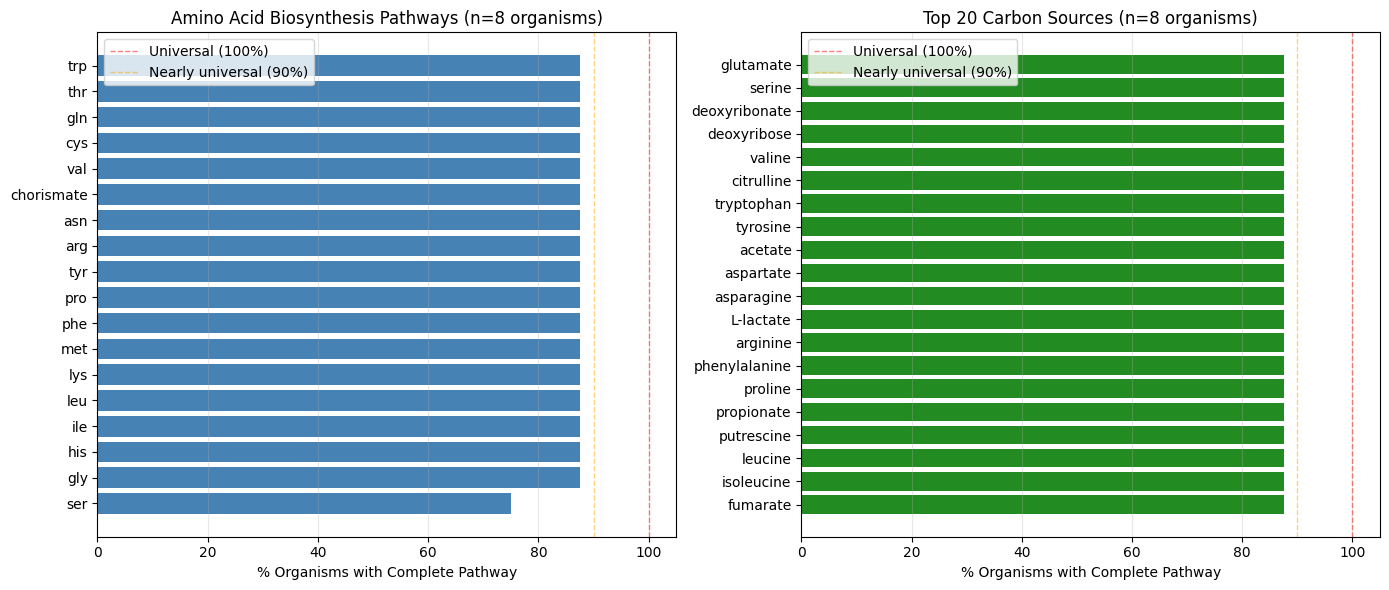

In [12]:
# Create visualization of pathway completeness

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Amino acid pathways
aa_pathways_sorted = aa_pathways.sort_values('pct_complete')
ax1.barh(aa_pathways_sorted['pathway'], aa_pathways_sorted['pct_complete'], color='steelblue')
ax1.axvline(100, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Universal (100%)')
ax1.axvline(90, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Nearly universal (90%)')
ax1.set_xlabel('% Organisms with Complete Pathway')
ax1.set_title(f'Amino Acid Biosynthesis Pathways (n={n_genomes} organisms)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Top carbon sources
top_carbon = carbon_pathways.head(20).sort_values('pct_complete')
ax2.barh(top_carbon['pathway'], top_carbon['pct_complete'], color='forestgreen')
ax2.axvline(100, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Universal (100%)')
ax2.axvline(90, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Nearly universal (90%)')
ax2.set_xlabel('% Organisms with Complete Pathway')
ax2.set_title(f'Top 20 Carbon Sources (n={n_genomes} organisms)')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()

# Save figure
fig_dir = Path("../figures")
fig_dir.mkdir(exist_ok=True)
fig_path = fig_dir / "pathway_completeness.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved figure: {fig_path}")

plt.show()

## Save Results

In [13]:
# Save results
data_dir = Path("../data")
data_dir.mkdir(exist_ok=True)

# 1. Pathway completeness summary
pathway_file = data_dir / "pathway_completeness.tsv"
pathway_completeness.to_csv(pathway_file, sep='\t', index=False)
print(f"✅ Pathway completeness: {pathway_file}")

# 2. Universally complete pathways
if len(universal_pathways) > 0:
    universal_file = data_dir / "universal_pathways.tsv"
    universal_pathways.to_csv(universal_file, sep='\t', index=False)
    print(f"✅ Universal pathways: {universal_file}")

# 3. Nearly universal pathways
if len(nearly_universal) > 0:
    nearly_universal_file = data_dir / "nearly_universal_pathways.tsv"
    nearly_universal.to_csv(nearly_universal_file, sep='\t', index=False)
    print(f"✅ Nearly universal pathways: {nearly_universal_file}")

# 4. GapMind predictions for FB organisms
gapmind_file = data_dir / "gapmind_fb_predictions.tsv"
gapmind_with_org.to_csv(gapmind_file, sep='\t', index=False)
print(f"✅ GapMind predictions: {gapmind_file}")

# 5. Amino acid pathways
aa_file = data_dir / "aa_pathway_completeness.tsv"
aa_pathways.to_csv(aa_file, sep='\t', index=False)
print(f"✅ Amino acid pathways: {aa_file}")

# 6. Carbon source pathways
carbon_file = data_dir / "carbon_pathway_completeness.tsv"
carbon_pathways.to_csv(carbon_file, sep='\t', index=False)
print(f"✅ Carbon source pathways: {carbon_file}")

print(f"\n✅ All results saved to {data_dir}/")

✅ Pathway completeness: ../data/pathway_completeness.tsv
✅ GapMind predictions: ../data/gapmind_fb_predictions.tsv
✅ Amino acid pathways: ../data/aa_pathway_completeness.tsv
✅ Carbon source pathways: ../data/carbon_pathway_completeness.tsv

✅ All results saved to ../data/


In [14]:
# Clean up
spark.stop()
print("✅ Spark session closed")

✅ Spark session closed


## Summary

**Completed**:
- ✅ Loaded 45 FB organism names from essential_genome project
- ✅ Loaded manual genome mapping (8 organisms: Keio, DvH, MR1, Putida, PS, Caulo, Smeli, azobra)
- ✅ Retrieved GapMind pathway predictions for 8 mapped genomes
- ✅ Identified universally complete and nearly universal pathways
- ✅ Analyzed amino acid biosynthesis vs carbon source utilization
- ✅ Created visualizations

**Key Findings**:
- See output cells above for:
  - Number of universally complete pathways
  - Nearly universal pathways (≥90%)
  - Amino acid biosynthesis capabilities
  - Carbon source utilization patterns

**Next Steps**:
1. Expand genome mapping to include more of the 45 FB organisms
2. Compare results to minimal genome studies (JCVI-syn3.0)
3. Investigate organisms missing key pathways (auxotrophs)
4. Analyze pathway patterns by phylogenetic group